In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import sys
import tensorflow as tf
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

if 'google.colab' in sys.modules:
    print("setting tensorflow version in colab")

print(tf.__version__)

drive.mount('/content/drive')

setting tensorflow version in colab
2.16.1
Mounted at /content/drive


In [ ]:
# Cargar datos desde un archivo CSV, parsear las fechas y establecer la columna 'date' como índice
dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Monografía/datos_arbei/Datos_monografía.xlsx',
                        index_col=0, date_format='%Y %m %d')
dataset.index.name = 'date'
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset[['ndvi', 'precipitation', 'soil_moisture', 'recharge']]

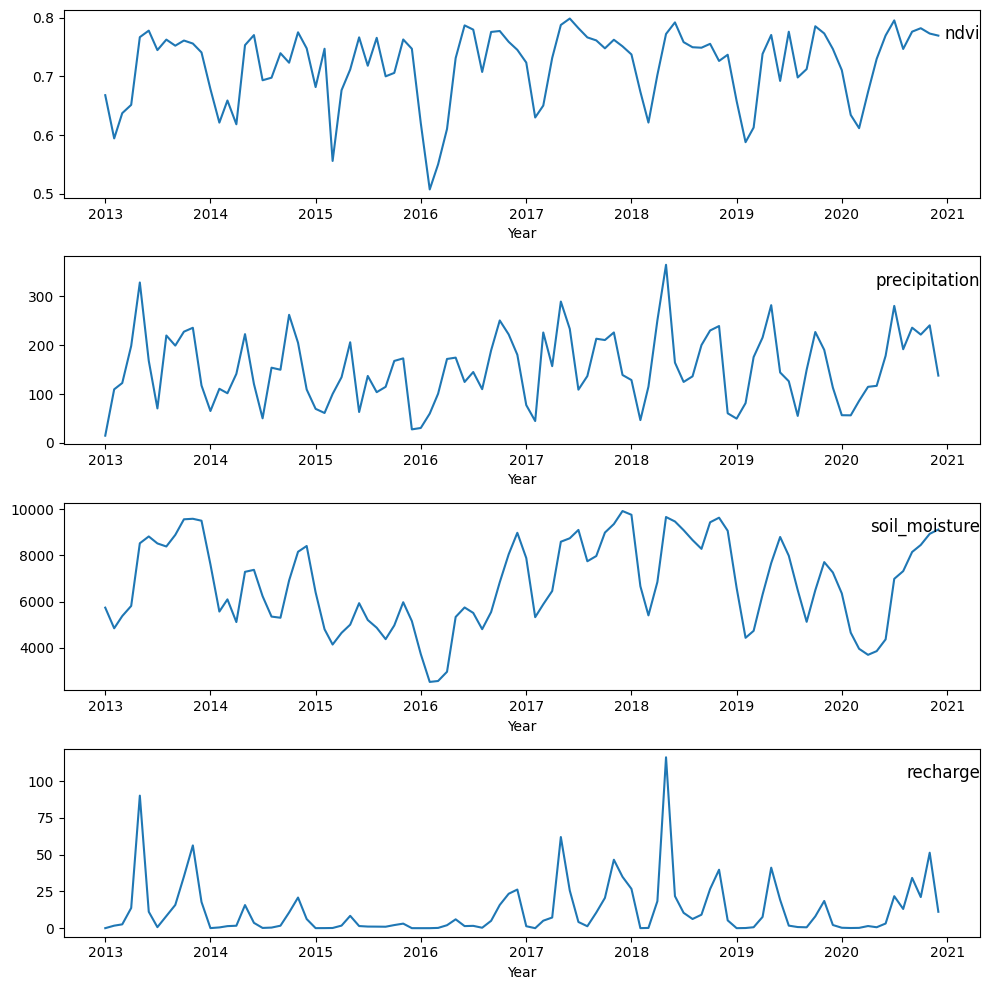

In [ ]:
# Visualización de datos
groups = [0, 1, 2, 3]
plt.figure(figsize=(10, 10))
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i + 1)
    plt.plot(dataset.index, dataset.iloc[:, group])
    plt.title(dataset.columns[group], y=0.8, loc='right')
    plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
# Función para crear secuencias
def create_sequences(data, n_past_steps=1, n_forecast_steps=1, n_overlay_steps=1, include_target_as_feature=False):
    x_sequence = []
    y_sequence = []
    start_idx = 0
    while True:
        end_idx = start_idx + n_past_steps
        forecast_end_idx = end_idx + n_forecast_steps
        if forecast_end_idx > len(data):
            break
        if include_target_as_feature:
            x = data[start_idx:end_idx]
        else:
            x = data[start_idx:end_idx, 1:]
        y = data[end_idx:forecast_end_idx, 0]
        x_sequence.append(x)
        y_sequence.append(y)
        start_idx += n_overlay_steps
    return np.array(x_sequence), np.array(y_sequence)

In [ ]:
n_past_steps = 1
n_forecast_steps = 1
n_overlay_steps = 1
n_features = 3

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset.values)

# División en datos de entrenamiento y prueba
train_size = int(len(dataset) * 0.8)
train_scaled = dataset_scaled[:train_size]
test_scaled = dataset_scaled[train_size:]

# Creación de secuencias
X_all, y_all = create_sequences(dataset_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)
X_train, y_train = create_sequences(train_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)
X_test, y_test = create_sequences(test_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)

# Convertir a tensores de TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_all_tensor = tf.convert_to_tensor(X_all, dtype=tf.float32)
y_all_tensor = tf.convert_to_tensor(y_all, dtype=tf.float32)

In [ ]:
# Definir y compilar el modelo LSTM
tf.keras.backend.clear_session()
n_past_steps = 1
n_features = 3

modelLSTM = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_past_steps, n_features)),
    tf.keras.layers.LSTM(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
], name='lstm')

loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
modelLSTM.compile(loss=loss, optimizer=optimizer, metrics=['mae', 'mse'])

monitor_metric = 'val_mae'
model_filename = 'ndvi_LSTM_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Monografía/modelos/' + model_filename,
    monitor=monitor_metric,
    save_best_only=True,
    mode='min' if monitor_metric in ['val_loss', 'val_mae'] else 'max',
    verbose=1)

# Entrenamiento del modelo
history = modelLSTM.fit(X_train_tensor, y_train_tensor, batch_size=5, epochs=300, validation_data=(X_test_tensor, y_test_tensor), callbacks=[model_checkpoint_callback], verbose=1)

Epoch 1/300
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2763 - mae: 0.7160 - mse: 0.5525
Epoch 1: val_mae improved from inf to 0.60236, saving model to /content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_LSTM_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.2605 - mae: 0.6917 - mse: 0.5210 - val_loss: 0.1963 - val_mae: 0.6024 - val_mse: 0.3927
Epoch 2/300
 1/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.2099 - mae: 0.6135 - mse: 0.4199
Epoch 2: val_mae improved from 0.60236 to 0.28749, saving model to /content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_LSTM_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1449 - mae: 0.4958 - mse: 0.2898 - val_loss: 0.0516 - val_mae: 0.2875 - val_mse: 0.1033
Epoch 3/300
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - mae: 0.2130 - mse: 0.0568 
Epoch 3: val_mae improved from 0.28749 to 0.13217, saving model to /content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_LSTM_model.keras
15/15

In [ ]:
saved_model = load_model('/content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_LSTM_model.keras')

# Predicciones y evaluación con el conjunto de prueba
y_pred_test = saved_model.predict(X_test_tensor)
evaluation = saved_model.evaluate(X_test_tensor, y_test_tensor)

# Métricas
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - loss: 0.0085 - mae: 0.1062 - mse: 0.0170
MAE: 0.10619006783219284
MSE: 0.016988874063277714
RMSE: 0.13034137510122298
R2: 0.46137954847899876


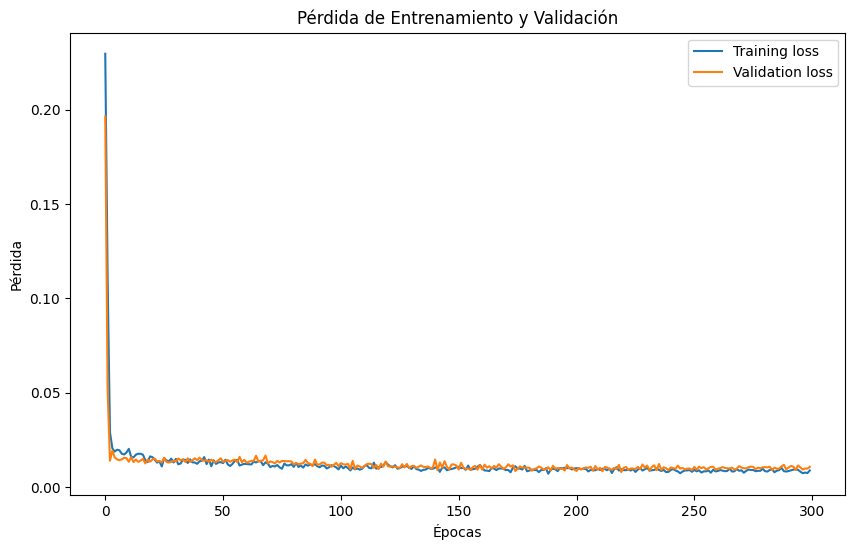

In [ ]:
# Gráfica de pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


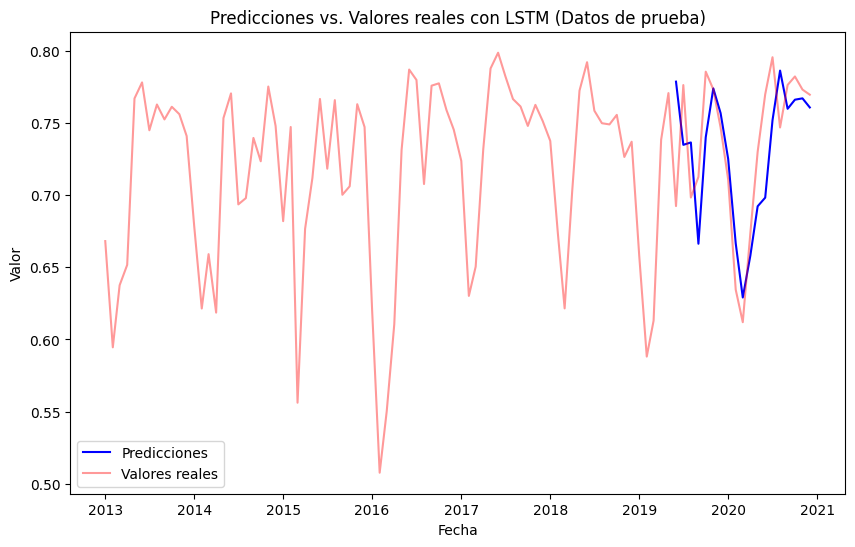

In [ ]:
y_pred_model = saved_model.predict(X_test_tensor)

# Convertir las predicciones y valores reales a su escala original
y_pred_model_inv = scaler.inverse_transform(np.concatenate((y_pred_model, np.zeros((y_pred_model.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
y_sca_inv = scaler.inverse_transform(np.concatenate((y_all, np.zeros((y_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

# Obtener las fechas correspondientes a las predicciones
dates = dataset.index[-len(y_pred_model):]

# Graficar predicciones vs. valores reales
plt.figure(figsize=(10, 6))
plt.plot(dates, y_pred_model_inv, label='Predicciones', color='blue')
plt.plot(dataset.index, dataset['ndvi'], label='Valores reales', color='red', alpha=0.4)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs. Valores reales con LSTM (Datos de prueba)')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


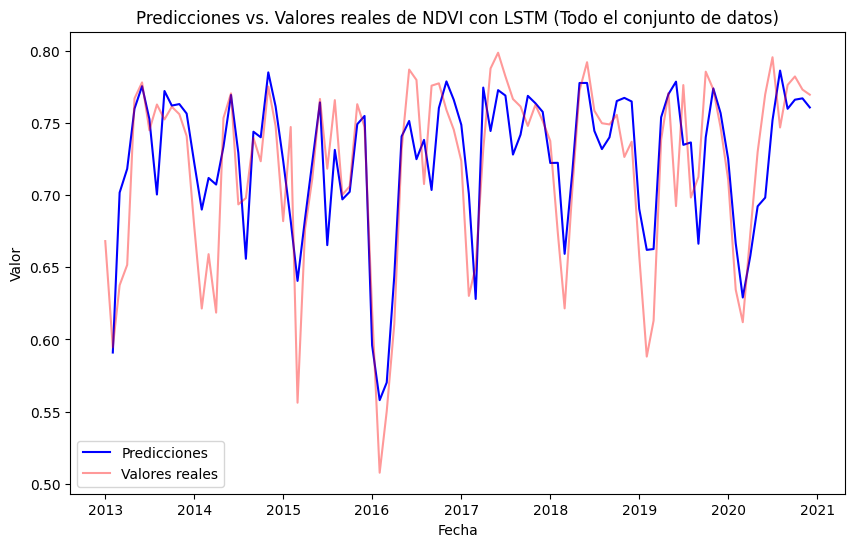

In [ ]:
# Realizar predicciones en el conjunto completo de datos
y_pred_all = saved_model.predict(X_all_tensor)

# Convertir las predicciones y valores reales a su escala original
y_pred_all_inv = scaler.inverse_transform(np.concatenate((y_pred_all, np.zeros((y_pred_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
y_all_inv = scaler.inverse_transform(np.concatenate((y_all.reshape(-1, 1), np.zeros((y_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

# Obtener las fechas correspondientes a las predicciones
all_dates = dataset.index[n_past_steps: n_past_steps + len(y_pred_all)]

# Graficar predicciones vs. valores reales en todo el conjunto de datos
plt.figure(figsize=(10, 6))
plt.plot(all_dates, y_pred_all_inv, label='Predicciones', color='blue')
plt.plot(dataset.index, dataset['ndvi'], label='Valores reales', color='red', alpha=0.4)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs. Valores reales de NDVI con LSTM (Todo el conjunto de datos)')
plt.legend()
plt.show()